# ASSIGNMENT 3                                            McGill:COMP766-2  Winter 2020 


The objective of this assignment is to implement loopy belief propagation, and mean-field method for the Ising model, which we saw last time. Below is a review from the last assignment.

#### Ising model
The Ising model is fully expressed using a symmetric adjacency matrix $A$ (```adj```):
\begin{align}
  p(x) = \frac{1}{Z} \exp(\sum_{i} A_{i,i}x_i + \sum_{i,j < i} x_i A_{i,j}x_j) \quad x_i \in \{-1,+1\}
\end{align}
In words, the diagonal of $A$ represents the local field and interactions are captured by the remaining non-zero elements of $A$ (It is customary to have a negative sign in front of the summation, but for simplicity we dropped it.)
The graph structure can also be inferred from the sparsity patter of $A$.
Here, we are interested in deterministic sum-product inference.


## Problem 1.  Loopy Belief Propagation

### 1.a. (10 pts) 
Complete the implementation of loopy-BP below. (The base ```Inference``` class as well as ```CliqueTreeInference``` are included in the ```inference.py``` helper file.) 
Recall that the BP message $m_{i \to j}$ for a pairwise MRF is the product of all incoming messages, and the relevant factors, marginalized over $x_i$. For the Ising model this is:
\begin{align} 
m_{i \to j}(x_j) \propto (1-\alpha) m^{old}_{i \to j}(x_j) \, + \, \alpha \sum_{x_i \in \{-1,+1\}} \left ( \exp(x_i A_{i,i} + x_i A_{i,j} x_j) \prod_{k \in Nb(i)-j} m_{k \to i}(x_i) \right )
\end{align}
where $\alpha$ called the damping factor helps with the convergence. After convergence the marginals are:
\begin{align}
p(x_i) \propto \exp(x_i A_{i,i}) \prod_{j \in Nb(i)} m_{j \to i}(x_i)
\end{align}

In the implementation below:
Try to use only a single loop, which runs for a maximum of ```self.max_iters```. If you find this too challenging you can also loop over individual messages.
The iterations should terminate as soon as the maximum change in the absolute value of the marginals in two iterations goes below ```self.eps```. To help with convergence you can damp (smoothed) your message update using the damping parameter ```self.damping``` 

#### using log-ratio of messages
When dealing with a binary domain, it is more efficient to only track a single probability value (rather two values for the message $m_{i \to j}(-1), m_{i \to j}(+1)$ in the case of Ising model. Because this is redundant.) In fact, for numerical stability, it is convenient to track only the log-ratio $\mu_{i \to j} = \log \left( \frac{m_{i \to j}(+1)}{m_{i \to j}(-1)} \right )$. One could then try and rewrite the message update using $\mu$ rather original $m$. This enables us to only track $\mu$, and after convergence produce marginals using these log-ratios. we can also write the marginals for this setting. For this you need to substitute $m(1) = \frac{1}{1 + e^{-\mu}} = \sigma(\mu)$ and $m(-1) = 1 - \sigma(\mu)$ in the update equation above and simplify (if you decide __not__ to use log-ratios you may need to update other parts of the code below, which was written based on this assumption)

### 1.a. solution

In [11]:
import numpy as np
import matplotlib.pylab as plt
import networkx as nx
np.random.seed(12345)
import timeit
#removing some warnings!
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from utils import tensor_mult, draw_graph, logistic
from inference import Inference, CliqueTreeInference
from IPython.core.debugger import set_trace
import time
import matplotlib.pyplot as plt

class LBPInference(Inference):
    """
    implements sum-product loopy belief propagation inference 
    for  p(x) \propto exp(+\sum_{i,j<i} x_i x_j adj[i,j] + \sum_{i} x_i adj[i,i]) for  x_i \in {-1,+1}
    """
    def __init__(self,
                 adj,
                 verbosity=0,
                 max_iters=1000,  # max number of iterations
                 damping=.1,  # damping=0 means no damping
                 eps=1e-16,  # threshold for convergence
    ):
        Inference.__init__(self, adj, verbosity=verbosity)
        self.damping = damping
        self.max_iters = max_iters
        # (i,j)th element is the log-ratio of message i->j
        self.msg_new = None
        self.msg_old = None
        self.marginals = None
        self.converged = False
        self.mask = None  # zero-one mask for the adjacency (zero diagonals)
        self.eps = eps
        self._initialize()
        self.adj = adj

    def update_adjacency(self, new_adj):
        self.adj = new_adj
        self._initialize()

    def _initialize(self):
        n = self.adj.shape[0]
        self.msg_new = np.zeros((n , n))
        self.msg_old = np.zeros((n , n))
        self.marginals = np.zeros(n)
        mask = (self.adj != 0)
        np.fill_diagonal(mask, 0)
        self.mask = mask
        self.converged = False

    def _apply_damping(self, msg_new, msg_old):
        #convert to probability
        msg_new_p = logistic(msg_new)
        msg_old_p = logistic(msg_old)
        msg_p = msg_old_p * (self.damping) + msg_new_p * (1. - self.damping)
        # convert back to log-ratio
        msg = np.log(msg_p) - np.log(1. - msg_p)
        return msg
    
    def _inference(self):
        if self._verbosity > 0:
            print("running BP", flush = True)
        self._initialize()
        
        n = self.adj.shape[0]
        
        old_marginals = np.zeros(n)
        new_marginals = np.zeros(n)
 

        for ـ in range(self.max_iters):
            for i in range(n):
                for j in range(n):
                    q1 = 1
                    q0 = 1
                    if self.mask[i,j] != 0:
                        # Fing j's neighbors
                        for k in range(n):
                            if self.mask[k,i] !=0 and j!=k:
                                msg_old_p = logistic(self.msg_old[k,i])
                                q1 = q1*msg_old_p
                                q0 = q0*(1-msg_old_p)

                        new_p1 = q1*np.exp(self.adj[i,i]+self.adj[i,j]) + q0*np.exp(-self.adj[i,i]-self.adj[i,j])
                        new_p0 = q1*np.exp(self.adj[i,i]-self.adj[i,j]) + q0*np.exp(-self.adj[i,i]+self.adj[i,j])
                        
                        msg_new_p = (new_p1)/(new_p1+new_p0)
                        self.msg_new[i,j] = np.log(msg_new_p) - np.log(1.-msg_new_p)
                        self.msg_new[i,j] = self._apply_damping(self.msg_new[i,j],self.msg_old[i,j])
    
            for i in range(n):
                mrg1 = 1
                mrg0 = 1
                for j in range(n):
                    if self.mask[j,i]!=0:
                        q1 = logistic(self.msg_new[j,i])
                        mrg1 = mrg1*q1
                        mrg0 = mrg0*(1.-q1)
                marginal = (np.exp(self.adj[i,i])*mrg1)/(np.exp(self.adj[i,i])*mrg1+np.exp(-self.adj[i,i])*mrg0)
                
                new_marginals[i] = marginal
                new_marginals[i] = np.log(new_marginals[i]) - np.log(1-new_marginals[i])
            if np.linalg.norm(new_marginals-old_marginals,np.inf)<self.eps:
                break
            old_marginals = new_marginals.copy()
            self.msg_old = self.msg_new.copy()

        
        # >>>> YOUR CODE HERE >>>>>>>

        # >>>> YOUR CODE HERE >>>>>>>

        self.marginals = new_marginals
        if self._verbosity > 0:
            print("finished after {} iterations!".format(t), flush = True)
                
    def get_marginal(self, target):
        if not self.converged:
            self._inference()
            self.converged = True
        mrg = logistic(self.marginals)[target]
        return mrg


If the implementation above is correct, it should return exact marginals for the tree structure below. You can use this to debug your code (We are comparing the ```LBPInference``` marginals against the exact values returned by ```CliqueTreeInference```.) 

In [12]:
#build a tree 
tree = nx.balanced_tree(3, 4)
n = nx.number_of_nodes(tree)
mask = np.array(nx.adjacency_matrix(tree).todense())
# create a random interaction over the edges
np.fill_diagonal(mask, 1.)
adj = mask * np.random.randn(n , n)
# make it symmetric
zero_inds = np.tril_indices_from(adj,-1)
adj[zero_inds] = 0        
adj += adj.T.copy()
# do inference
true_margs = CliqueTreeInference(adj).get_marginal(list(range(adj.shape[0])))            
bp_margs = LBPInference(adj).get_marginal(list(range(adj.shape[0])))
assert np.mean(np.abs(true_margs - bp_margs)) < 1e-10, "LBP marginals are not exact"

print("True",true_margs)
print("BP",bp_margs)

True [3.82170740e-01 5.04614579e-01 9.27716075e-01 2.08644237e-03
 5.98865377e-02 3.99468555e-02 9.80420759e-01 8.48612844e-01
 2.15927378e-05 1.90368943e-02 7.00279019e-04 9.25233719e-04
 2.57109069e-01 6.86188587e-01 5.30334606e-02 4.32046774e-04
 1.90243810e-01 6.98614692e-01 1.38997135e-01 9.15133134e-01
 2.25061544e-03 5.70967896e-05 9.94719012e-01 7.55847901e-01
 1.88333026e-01 2.80028679e-04 9.99994675e-01 9.50905447e-02
 4.03783700e-01 9.99800900e-01 9.99980483e-01 9.93120193e-01
 9.08142673e-01 3.52052280e-01 1.23808481e-03 8.37546875e-01
 9.63596003e-01 2.07818987e-01 5.18662365e-01 9.28713027e-01
 9.10719781e-01 8.58108421e-01 8.25261150e-01 1.81896700e-01
 1.04611799e-01 7.20417134e-03 9.98094449e-01 9.04964445e-01
 5.77956690e-02 1.42137728e-01 8.20313737e-01 2.08855659e-01
 6.77555218e-01 3.50179214e-03 5.06472808e-01 3.08424520e-01
 8.43471938e-01 2.66122025e-02 6.55820975e-03 2.57562606e-04
 1.79597251e-02 5.12488063e-03 9.87026326e-01 9.89386031e-01
 9.51998834e-01 9.9

### 1.c. (5 pts) 
apply it to $n×n$ 2D-grids (```grid_2d_graph```), of increasing size $n \in \{2, 4, 6, 8, 15\}$,
and compare its run-time with clique-tree. The x-axis in the plot is the number of nodes $n$ and y-axis is the run-time (use logarithmic scale). Repeat your experiment at least 10 times to produce an error-bars for your plot.


##### Answer:
As it is observable in the plot, the run-time of inferences are proportional to the graph size and LBP method is faster than CTI. specially in the bigger graphs the speed gap of LBP compared to CTI is significant.

### 1.c. solution

[0.00237038 0.00986195 0.03124723 0.07790203 1.03494961]
[0.00123596 0.00843451 0.02807875 0.07275796 0.57208703]


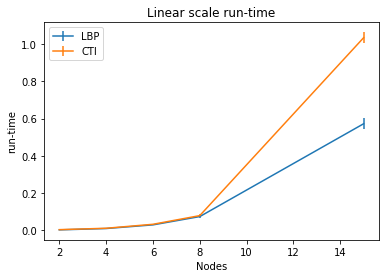

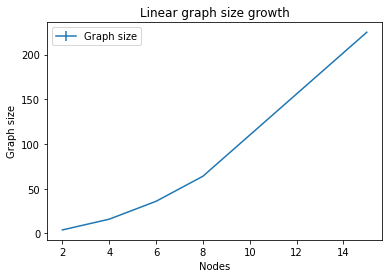

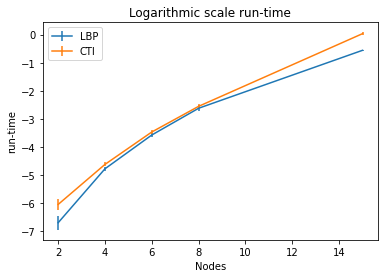

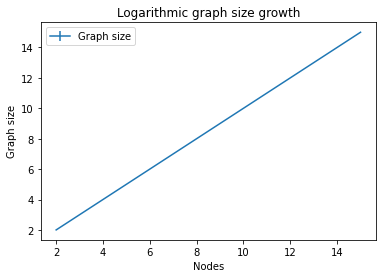

In [15]:

N = [2,4,6,8,15]


CTI = np.zeros((10,5))
LBP = np.zeros((10,5))
for n in range(5):
               
    G = nx.grid_2d_graph(N[n], N[n])
    mask = np.array(nx.adjacency_matrix(G).todense())
    np.fill_diagonal(mask, 1.)
    adj = mask * 1 
    np.fill_diagonal(adj, 0)
    zero_inds = np.tril_indices_from(adj,-1)
    adj[zero_inds] = 0
    adj += adj.T.copy()
    adj_size = adj.shape[0]

#     draw_graph(G=G)


    for i in range(10):

        start = time.time()#* 1000
        bp_margs = LBPInference(adj).get_marginal(list(range(adj_size)))
        end = time.time()#* 1000
        LBP[i,n] = end-start
        
        
        start = time.time()#* 1000
        true_margs = CliqueTreeInference(adj).get_marginal(list(range(adj_size)))    
        end = time.time()#* 1000
        CTI[i,n] = end-start



# Linear 
CTI_std = np.std(CTI,axis=0)
LBP_std = np.std(LBP,axis=0)

CTI_std_log = np.std(np.log(CTI),axis=0)
LBP_std_log = np.std(np.log(LBP),axis=0)

print(np.average(CTI,axis=0))
print(np.average(LBP,axis=0))

plt.errorbar(N,np.average(LBP,axis=0),yerr=LBP_std,label = 'LBP')
plt.errorbar(N,np.average(CTI,axis=0),yerr=CTI_std,label='CTI')

plt.legend()
plt.xlabel('Nodes')
plt.ylabel('run-time')
plt.title('Linear scale run-time')
plt.show()


plt.errorbar(N,np.power(N,2),yerr=[0,0,0,0,0],label = 'Graph size')
plt.legend()
plt.xlabel('Nodes')
plt.ylabel('Graph size')
plt.title('Linear graph size growth')
plt.show()


plt.errorbar(N,np.log(np.average(LBP,axis=0)),yerr=CTI_std_log,label = 'LBP')
plt.errorbar(N,np.log(np.average(CTI,axis=0)),yerr=LBP_std_log,label='CTI')

plt.legend()
plt.xlabel('Nodes')
plt.ylabel('run-time')
plt.title('Logarithmic scale run-time')
plt.show()

#Graph size growth
plt.errorbar(N,N,yerr=[0,0,0,0,0],label = 'Graph size')
plt.legend()
plt.xlabel('Nodes')
plt.ylabel('Graph size')
plt.title('Logarithmic graph size growth')
plt.show()


## Problem 2. Mean Field (15 pts)

### 2.a. (8 pts)
Complete the implementation of naive mean-field below. 
You can refer to slides for derivation of the updates for the Ising model.
In the implementation below: 
Try to use only a single loop, which repeats for a a maximum of ```self.max_iters```. 
The loop can terminate as soon as the maximum of the absolute value of change in the marginals 
between two iterations goes below ```self.eps```.
For better convergence try damping (smoothing) the updates, using the damping parameter ```self.damping```.

### 2.a. solution

In [7]:
class MFInference(Inference):
    """
    implements parallel update of naive mean-field for the Ising model
    mean-field is guaranteed to converge to a local optima, when updating 
    one coordinate at a time. Here, since for efficiency/simplicity we update all coordinates simultaneously,
    we may need to use damping to help with convergence
    for  p(x) \propto exp(+\sum_{i,j<i} x_i x_j adj[i,j] + \sum_{i} x_i adj[i,i]) for  x_i \in {-1,+1}
    """
    
    def __init__(self,
                 adj,  # adjacency matrix for the Ising model
                 verbosity=0,
                 max_iters=1000,  # max number of iterations
                 eps=1e-16,  # threshold for convergence
                 damping=.5, # because we are using parallel updates, 0 means no damping
    ):
        Inference.__init__(self, adj, verbosity=verbosity)
        self.damping = damping
        self.max_iters = max_iters
        # (i,j)th element is the log-ratio of message i->j
        self.means = None
        self.converged = False
        self.adj_masked = None  # adjacency matrix with zero diagonals
        self.eps = eps
        self._initialize()

    def update_adjacency(self, new_adj):
        self.adj = new_adj
        self._initialize()

    def _initialize(self):
        n = self.adj.shape[0]
        self.means = np.zeros(n)
        adj_masked = self.adj.copy()
        np.fill_diagonal(adj_masked, 0)
        self.adj_masked = adj_masked
        self.converged = False

    def _inference(self):
        if self._verbosity > 0:
            print("running MF", flush = True)
        # >>>> YOUR CODE HERE >>>>>>>

        # >>>> YOUR CODE HERE >>>>>>>
        
        self._initialize()
        
        n = self.adj.shape[0]
        q_old = np.random.uniform(-1,1,n)
        q_new = np.zeros(n)
        for _ in range(self.max_iters): 
            
            for i in range(n):
                m = self.adj[i,i].copy()
                for j in range(n):
                    if self.adj_masked[i,j] != 0:
                        m += self.adj[i,j]*q_old[j]         
                u1 = np.exp(m)/(np.exp(m)+np.exp(-m))
                u0 = np.exp(-m)/(np.exp(-m)+np.exp(m))
                q_new[i] = u1-u0
                q_new[i] = (self.damping*(q_old[i]) + (1-self.damping)*q_new[i]).copy()
#             print(np.linalg.norm(q_new-q_old,np.inf)," = ", self.eps) 
            if np.linalg.norm(q_new-q_old,np.inf)<self.eps:
                break
            q_old = q_new.copy()          
        self.means = q_new.copy()
        
        if self._verbosity > 0:
            print("finished after {} iterations!".format(t), flush = True)
                
    def get_marginal(self, target):
        if not self.converged:
            self._inference()
            self.converged = True
        # converting the mean ([-1,+1] range) to the p(x_i = 1) [0,1] range
        mrg = (self.means[target] + 1.)/2.
        return mrg
    
    

### 2.b (7 pts)
Now, we can can compare the accuracy of belief propagation and mean-field in approximate inference.
For this experiment, we use a fixed $15\times15$ 2D grid (without periodic boundaries).
To control the difficulty of the inference problem, we adjust the temperature parameter $T$.
This corresponds to multiplication of the adjacency matrix $A$ with a constant. Large temperatures,
correspond to lower values of interaction $A_{ij}$, which reduces interdependency of variables:
\begin{align}
  p^{\frac{1}{T}}(x) = \frac{1}{Z(T)} \exp(\frac{1}{T}\sum_{i} A_{i,i}x_i + \frac{1}{T} \sum_{i,j < i} x_iA_{i,j}x_j) \quad x_i \in \{-1,+1\}
\end{align}
We sample the non-zero elements of $A$, from a standard normal distribution, and adjust
the difficulty of approximate inference by changing $T \in \{2^{-4},2^{-3},\ldots, 2^{9}\}$.
Use the mean-absolute-error of all the univariate marginals as a measure of accuracy of approximate inference, and plot temperature-vs-accuracy for both naive mean-field and loopy belief propagation.
Note that to measure the _error_, first you have to perform _exact inference_ on the same graphical model using ```CliqueTreeInference```, to obtain the exact marginals.
Repeat the experiment 10 times and produce error-bars for your difficulty-vs-accuracy plot (use logarithmic scale for both x and y).
Summarize what you see in the plot.




##### Answer:

From the plots, it is observable that in the small temperatures, mean-field has bigger errors compared to loopy belief propagation. |However, as the temperature increases, there is a significant drop in mean-field error. And in higher temperatures, both MF and LBP have very small errors. LBP errors are much lower than MF in lower temperatures and don't change significantly as the temperature increases, but still, there is a small downward error trend as the temperature increases. It can be concluded that approximate inference models have higher accuracy when the temperature is higher, or in other words, there is lower interdependency between variables.




### 2.b solution


[-4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]


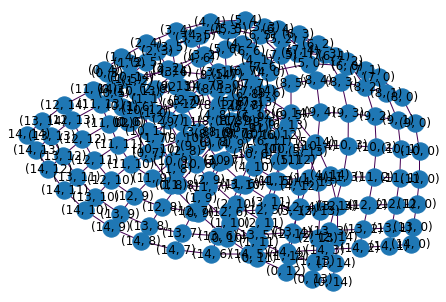

Temp= -4.0 Experiment No. 0
Temp= -4.0 Experiment No. 1
Temp= -4.0 Experiment No. 2
Temp= -4.0 Experiment No. 3
Temp= -4.0 Experiment No. 4
Temp= -4.0 Experiment No. 5
Temp= -4.0 Experiment No. 6
Temp= -4.0 Experiment No. 7
Temp= -4.0 Experiment No. 8
Temp= -4.0 Experiment No. 9
Temp= -3.0 Experiment No. 0
Temp= -3.0 Experiment No. 1
Temp= -3.0 Experiment No. 2
Temp= -3.0 Experiment No. 3
Temp= -3.0 Experiment No. 4
Temp= -3.0 Experiment No. 5
Temp= -3.0 Experiment No. 6
Temp= -3.0 Experiment No. 7
Temp= -3.0 Experiment No. 8
Temp= -3.0 Experiment No. 9
Temp= -2.0 Experiment No. 0
Temp= -2.0 Experiment No. 1
Temp= -2.0 Experiment No. 2
Temp= -2.0 Experiment No. 3
Temp= -2.0 Experiment No. 4
Temp= -2.0 Experiment No. 5
Temp= -2.0 Experiment No. 6
Temp= -2.0 Experiment No. 7
Temp= -2.0 Experiment No. 8
Temp= -2.0 Experiment No. 9
Temp= -1.0 Experiment No. 0
Temp= -1.0 Experiment No. 1
Temp= -1.0 Experiment No. 2
Temp= -1.0 Experiment No. 3
Temp= -1.0 Experiment No. 4
Temp= -1.0 Experimen

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

T = np.arange(-4,10,dtype=float)
print(T)

G = nx.grid_2d_graph(15, 15, periodic=False, create_using=None)
mask = np.array(nx.adjacency_matrix(G).todense(),dtype=np.longdouble)

np.fill_diagonal(mask, 1.)
n = G.number_of_nodes()
draw_graph(G=G)
adj = mask * 1 


repeat = 10

BP_error = np.zeros((repeat,len(T)),dtype=np.float)
MF_error = np.zeros((repeat,len(T)),dtype=np.float)

for idx,t in enumerate(T):

#     adj = mask * 1
    adj = mask / (2**t)
    np.fill_diagonal(adj, 0)
    zero_inds = np.tril_indices_from(adj,-1)
    adj[zero_inds] = 0
    adj += adj.T.copy()
    
    adj_size = adj.shape[0]

    for i in range(repeat):
        print("Temp=",t,"Experiment No.", i)
        cti_inference = CliqueTreeInference(adj).get_marginal(list(range(adj_size)))    
        bp_inference = LBPInference(adj).get_marginal(list(range(adj_size)))
        mf_inference = MFInference(adj).get_marginal(list(range(adj_size)))
        
        BP_error[i,idx] = mean_absolute_error(cti_inference, bp_inference)
        MF_error[i,idx] = mean_absolute_error(cti_inference, mf_inference)





[0.00000000e+00 0.00000000e+00 1.23259516e-32 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.54074396e-33 3.08148791e-33
 0.00000000e+00 0.00000000e+00]
[4.96903995e-03 4.00616381e-03 4.27970180e-03 5.63819170e-03
 3.68698466e-03 9.16941954e-03 4.19570694e-07 5.09598923e-18
 8.96350988e-18 3.08385416e-18 7.64422273e-19 7.25194643e-19
 1.14264511e-18 6.63845475e-19]


<ipython-input-14-2a08a33706ba>:4: RuntimeWarning: divide by zero encountered in log
  BP_yerr_log = np.std(np.log(BP_error),axis =0)


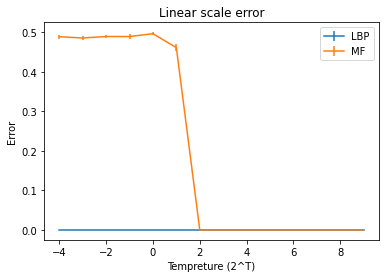

<ipython-input-14-2a08a33706ba>:20: RuntimeWarning: divide by zero encountered in log
  plt.errorbar(T,np.log(np.average(BP_error,axis=0)),yerr=BP_yerr_log,label='LBP')


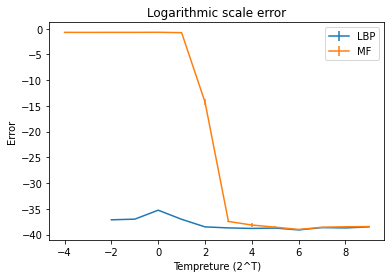

In [14]:


BP_yerr = np.std(BP_error,axis =0)
MF_yerr = np.std(MF_error, axis =0)

BP_yerr_log = np.std(np.log(BP_error),axis =0)
MF_yerr_log = np.std(np.log(MF_error), axis =0)


print(BP_yerr)
print(MF_yerr)

plt.errorbar(T,np.average(BP_error,axis=0),yerr=BP_yerr,label='LBP')
plt.errorbar(T,np.average(MF_error,axis=0),yerr=MF_yerr,label = 'MF')
plt.legend()
plt.xlabel('Tempreture (2^T)')
plt.ylabel('Error')
plt.title('Linear scale error')
plt.show()


plt.errorbar(T,np.log(np.average(BP_error,axis=0)),yerr=BP_yerr_log,label='LBP')
plt.errorbar(T,np.log(np.average(MF_error,axis=0)),yerr=MF_yerr_log,label = 'MF')
plt.legend()
plt.xlabel('Tempreture (2^T)')
plt.ylabel('Error')
plt.title('Logarithmic scale error')
plt.show()

